#### source: https://towardsdatascience.com/building-a-book-recommendation-system-using-keras

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from tensorflow.keras.models import Model

warnings.filterwarnings('ignore')
%matplotlib inline

#### Loading in data

In [4]:
dataset = pd.read_csv('data/ratings.csv')

In [5]:
dataset.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [6]:
dataset.shape

(981756, 3)

In [7]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

In [8]:
train.head()

,book_id,user_id,rating
341848,3423,4608,2
964349,9811,36373,5
645459,6485,2957,4
74960,750,42400,3
358670,3591,36886,5


In [9]:
test.head()

,book_id,user_id,rating
646451,6495,19643,5
614851,6175,8563,4
974393,9920,52110,3
21471,215,33864,5
272540,2728,16587,3


In [10]:
n_users = len(dataset.user_id.unique())
n_users

53424

In [11]:
n_books = len(dataset.book_id.unique())
n_books

10000

#### Creating dot product model
<font size="3">Most recommendation systems are build using a simple dot product as shown below but newer ones are now implementing a neural network instead of the simple dot product.</font>

In [13]:
# creating book embedding path
book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(n_books+1, 5, name="Book-Embedding")(book_input)
book_vec = Flatten(name="Flatten-Books")(book_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# performing dot product and creating model
prod = Dot(name="Dot-Product", axes=1)([book_vec, user_vec])
model = Model([user_input, book_input], prod)
model.compile('adam', 'mean_squared_error')

Train on 785404 samples
Epoch 1/5
785404/785404 [==============================] - 36s 46us/sample - loss: 14.2962
Epoch 2/5
785404/785404 [==============================] - 36s 46us/sample - loss: 5.1450
Epoch 3/5
785404/785404 [==============================] - 37s 47us/sample - loss: 1.8489
Epoch 4/5
785404/785404 [==============================] - 37s 47us/sample - loss: 1.2046
Epoch 5/5
785404/785404 [==============================] - 37s 47us/sample - loss: 0.9602


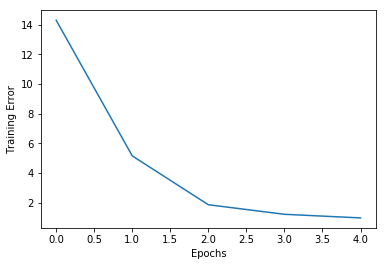

In [14]:
from tensorflow.keras.models import load_model

training = True
if not training and os.path.exists('model/regression_model.h5'):
    model = load_model('model/regression_model.h5')
else:
    history = model.fit([train.user_id, train.book_id], train.rating, epochs=5, verbose=1)
    model.save('model/regression_model.h5')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [15]:
model.evaluate([test.user_id, test.book_id], test.rating)

196352/196352 [==============================] - 3s 13us/sample - loss: 1.1833


1.183326464486363

In [16]:
predictions = model.predict([test.user_id.head(10), test.book_id.head(10)])

for i in range(0,10):
    print(predictions[i], test.rating.iloc[i])

[5.3505244] 5
[3.5619454] 4
[3.1916742] 3
[4.2762346] 5
[3.4195797] 3
[3.5269186] 3
[4.64038] 3
[5.012166] 4
[4.7268953] 3
[4.234318] 5


#### Creating Neural Network
<font size="3">Neural Networks proved there effectivness for almost every machine learning problem as of now and they also perform exceptionally well for recommendation systems.</font>

In [17]:
# creating book embedding path
book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(n_books+1, 5, name="Book-Embedding")(book_input)
book_vec = Flatten(name="Flatten-Books")(book_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([book_vec, user_vec])

# add fully-connected-layers
fc1 = Dense(128, activation='relu')(conc)
fc2 = Dense(32, activation='relu')(fc1)
out = Dense(1)(fc2)

# Create model and compile it
model2 = Model([user_input, book_input], out)
model2.compile('adam', 'mean_squared_error')

Train on 785404 samples
Epoch 1/5
785404/785404 [==============================] - 41s 52us/sample - loss: 0.7289
Epoch 2/5
785404/785404 [==============================] - 41s 52us/sample - loss: 0.6817
Epoch 3/5
785404/785404 [==============================] - 41s 52us/sample - loss: 0.6578
Epoch 4/5
785404/785404 [==============================] - 41s 52us/sample - loss: 0.6352
Epoch 5/5
785404/785404 [==============================] - 42s 53us/sample - loss: 0.6128


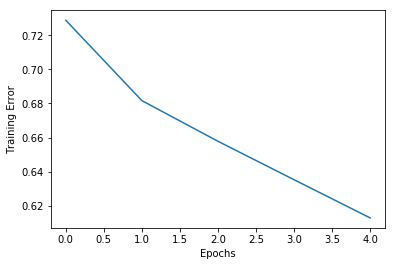

In [19]:
from tensorflow.keras.models import load_model

training = True
if not training and os.path.exists('model/regression_model2.h5'):
    model2 = load_model('model/regression_model2.h5')
else:
    history = model2.fit([train.user_id, train.book_id], train.rating, epochs=5, verbose=1)
    model2.save('model/regression_model2.h5')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [20]:
model2.evaluate([test.user_id, test.book_id], test.rating)

196352/196352 [==============================] - 3s 16us/sample - loss: 0.7080


0.7080266931139156

In [21]:
predictions = model2.predict([test.user_id.head(10), test.book_id.head(10)])

[print(predictions[i], test.rating.iloc[i]) for i in range(0,10)]

[5.064437] 5
[3.8119206] 4
[3.419963] 3
[3.9715729] 5
[3.3526182] 3
[4.129182] 3
[3.7006087] 3
[4.8022265] 4
[4.062069] 3
[3.9441462] 5


[None, None, None, None, None, None, None, None, None, None]

#### Visualizing Embeddings
<font size="3">Embeddings are weights that are learned to represent some specific variable like books and user in our case and therefore we can not only use them to get good results on our problem but also to extract inside about our data.</font>

In [ ]:
# Extract embeddings
book_em = model.get_layer('Book-Embedding')
book_em_weights = book_em.get_weights()[0]

In [ ]:
book_em_weights[:5]

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [ ]:
book_em_weights = book_em_weights / np.linalg.norm(book_em_weights, axis = 1).reshape((-1, 1))
book_em_weights[0][:10]
np.sum(np.square(book_em_weights[0]))

In [ ]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tnse_results = tsne.fit_transform(book_em_weights)

In [ ]:
sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1])

#### Making Recommendations
<font size="3">Making recommendations using our trained model is simple. We only need to feed in a user and all books and then select the books which have the highest predicted ratings for that specific user.</font>

In [45]:
# Creating dataset for making recommendations for the first user
book_data = np.array(list(set(dataset.book_id)))

# user id 1185
user = np.array([1185 for i in range(len(book_data))])

In [49]:
predictions = model.predict([user, book_data])
predictions = np.array([a[0] for a in predictions])
recommended_book_ids = (-predictions).argsort()[:10]

# print predicted scores
predictions[recommended_book_ids]

array([7.777305 , 7.1098013, 6.553552 , 6.1622057, 6.1544085, 5.984081 ,
       5.8992615, 5.883105 , 5.693368 , 5.690825 ], dtype=float32)

In [50]:
books[books['id'].isin(recommended_book_ids)]

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
4776,4777,426025,426025,2902834,20,675093244,9.780675e+12,William Faulkner,1930.0,A Rose for Emily,...,22629,23045,419,287,1072,4609,8091,8986,https://images.gr-assets.com/books/1487468453m...,https://images.gr-assets.com/books/1487468453s...
5433,5434,199687,199687,2975812,14,609807919,9.780610e+12,Megan McCafferty,2003.0,"Second Helpings (Jessica Darling, #2)",...,23180,23834,831,290,960,4680,8457,9447,https://images.gr-assets.com/books/1388707744m...,https://images.gr-assets.com/books/1388707744s...
5604,5605,12924261,12924261,18079704,23,312546343,9.780313e+12,David Wong,2012.0,NaN,...,15031,18053,1702,94,381,2466,6967,8145,https://images.gr-assets.com/books/1365496944m...,https://images.gr-assets.com/books/1365496944s...
5857,5858,16297,16297,894955,171,425205959,9.780425e+12,Agatha Christie,1936.0,Cards on the Table,...,19577,23004,1031,112,857,6468,9372,6195,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
6245,6246,8447255,8447255,13311158,25,593046358,9.780593e+12,Steven Erikson,2011.0,The Crippled God,...,14472,16590,720,133,392,1553,4461,10051,https://images.gr-assets.com/books/1320388198m...,https://images.gr-assets.com/books/1320388198s...
7738,7739,3268926,3268926,3132696,22,141659485X,9.781417e+12,Glenn Beck,2008.0,The Christmas Sweater,...,12916,13413,2361,417,1064,3409,4573,3950,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
7859,7860,132688,132688,758985,6,679747656,9.780680e+12,Julia Child,1989.0,The Way to Cook,...,11500,11656,102,185,288,1512,3447,6224,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
8257,8258,18594594,18594594,26341000,41,345547497,9.780346e+12,Karin Slaughter,2014.0,Cop Town,...,10660,13997,1704,274,780,3299,5612,4032,https://images.gr-assets.com/books/1384822680m...,https://images.gr-assets.com/books/1384822680s...
9121,9122,15768536,15768536,21474681,3,NaN,NaN,Christine Zolendz,2012.0,NaN,...,20488,20547,1387,514,1088,3565,7451,7929,https://images.gr-assets.com/books/1349538226m...,https://images.gr-assets.com/books/1349538226s...
9688,9689,113091,113091,2115367,66,375701230,9.780376e+12,James Agee,1957.0,A Death in the Family,...,10900,11678,843,257,759,2634,4060,3968,https://images.gr-assets.com/books/1327885315m...,https://images.gr-assets.com/books/1327885315s...
